In [686]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
import spacy

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

import gensim
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

import logging
from tqdm import tqdm
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [683]:
yelp_reviews = pd.read_pickle('./yelp_reviews_df.pkl')

In [684]:
yelp_reviews.head()

,reviews,total,possible_languages
'āina,"[{'id': '0J2EIqZij53TR8_KqyS5MQ', 'url': 'http...",939,[en]
100% Sweet Cafe,"[{'id': 'gbMTDQ-ZdeH0hQ-Q9aW0Kw', 'url': 'http...",532,"[en, zh]"
1275 café,"[{'id': 'AxS7Mw7RHCCwUfdccsT0UQ', 'url': 'http...",1,[en]
20th Salon and Barber,"[{'id': 'up3Okf9LgrXFsepsUnuvwg', 'url': 'http...",354,[en]
23rd & Mission Produce,"[{'id': 'yJNP6oGr1-ibk6Caf5VczQ', 'url': 'http...",22,[en]


After loading in and glancing at the format of my yelp review data, I realized that I needed to get rid of all reviews that didnt list english as a possible language. I iterate through the rows looking for 'en' and get rid of rows where english isnt present.

In [687]:
yelp_reviews['english'] = 0

for idx, row in yelp_reviews.iterrows():
    
    language_list = yelp_reviews.possible_languages[idx]
    
    for language in language_list:
        if language == 'en':
            yelp_reviews['english'][idx] = 1
            
yelp_reviews = yelp_reviews[yelp_reviews.english != 0]

del yelp_reviews['english']
del yelp_reviews['possible_languages']

yelp_reviews.reset_index(inplace=True)

Next I take a look at the format of the reviews column and see that its nested in a dictionary. I iterate through and pull out the text of the reviews for each business. Join them together and place them in a new dataframe column called 'reviews_text'.

In [688]:
yelp_reviews['reviews'][0][0]

{'id': '0J2EIqZij53TR8_KqyS5MQ',
 'url': 'https://www.yelp.com/biz/%C4%81ina-san-francisco-9?adjust_creative=TvefY9qcoJ-ds6nNHf3iZA&hrid=0J2EIqZij53TR8_KqyS5MQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=TvefY9qcoJ-ds6nNHf3iZA',
 'text': "It's been months since I had a lovely meal with friends at āina, and I can still remember how tasty it was. My experience with Hawaiian cuisine is quite...",
 'rating': 5,
 'time_created': '2018-12-31 17:10:31',
 'user': {'id': 'uHA2E62LB8EnQMr4DUALBw',
  'profile_url': 'https://www.yelp.com/user_details?userid=uHA2E62LB8EnQMr4DUALBw',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/rXNqbuJVCn8GPISHyIks5Q/o.jpg',
  'name': 'Keith H.'}}

In [689]:
yelp_reviews['reviews_text'] = np.nan

for idx, row in yelp_reviews.iterrows():
    
    reviews_list = yelp_reviews['reviews'][idx]
    
    all_reviews = ''
    
    for review in reviews_list:
        
        all_reviews = all_reviews + review['text'] + ' '
        
    yelp_reviews['reviews_text'][idx] = all_reviews
    
yelp_reviews['reviews_text'][0]

"It's been months since I had a lovely meal with friends at āina, and I can still remember how tasty it was. My experience with Hawaiian cuisine is quite... This place was on my list for quite some time, and it's a really good thing I went when I did because they mysteriously temporarily closed the next week!... I'm not the one to rush to new places when they open because of the long waits. And when this 40 seater restaurant opened, I thought, I'll wait to see if... "

My next step is to clean the text, I remove everything except the english alphabet, remove short words that provide no value to the overall review topic, and make all of my text lowercase for cleaner topic modeling.

In [690]:
yelp_reviews['reviews_text'] = yelp_reviews['reviews_text'].str.replace("[^a-zA-Z#]", " ")
yelp_reviews['reviews_text'] = yelp_reviews['reviews_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
yelp_reviews['reviews_text'] = yelp_reviews['reviews_text'].apply(lambda x: x.lower())

After that, I broke apart the sentences into words and put all of the words in a list. I removed english stop words and domain specific stop words as I was not looking for sentiment of the business, just aspects about the business and what they offer. I lemmatized the words and made a list of the cleaned reviews.

In [691]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
clean_reviews_list = yelp_reviews.reviews_text.tolist()
        
split_reviews = list(sent_to_words(clean_reviews_list))

all_words = [word for review in split_reviews for word in review]

for word in all_words:
    word = word.lower()

In [692]:
domain_stopwords = ['place', 'this_place', 'good', 'nice', 'love', 'great', 'super', 'time', 'find', 'they_have', 
                    'try', 'get', 'go', 'bad', 'review', 'find', 'spot', 'come', 'visit', 'work', 'service', 'leave',
                     'year', 'have_been', 'friend', 've', 'awesome', 'amazing', 'came_here', 'there_are', 'look', 
                     'item', 'start', 'star', 'little', 'we_were', 'buy', 'stop', 'way', 'option', 'order', 'close',
                    'open', 'they_are', 'thing', 'definitely', 'city', 'guy', 'people', 'has_been', 'one_of', 'many',
                     'live', 'need', 'know', 'today', 'this_store', 'excellence', 'don', 'know', 'think', 'area', 
                    'came_in', 'irv', 'for_year', 'want_to', 'want', 'will_never', 'you_can_get', 'my_life', 'back',
                    'decided_to_try', 'usually', 'street', 'overall', 'first_time', 'hour', 'my_friend', 'my_favorite', 
                    'san_francisco', 'so_many', 'come_here', 'they_were', 'minute', 'recommend', 'exist', 'recently',
                    'ask', 'line', 'remember', 'do_not', 'expect', 'to_be', 'post', 'prices_are', 'grandma', 'since',
                    'especially', 'perfect', 'job', 'quick', 'initially', 'finally', 'wasn', 'bring', 'lose', 'times',
                    'didn', 'based_on', 'man', 'going_to', 'bay', 'we_got', 'see_if', 'week', 've_had', 'pair_of',
                    'pay', 'change', 'lady', 'lee', 'park','parking', 'maybe', 'actually', 'yelp', 'came_back', 
                     'person', 'low', 'women', 'doesn', 'stumble', 'if_you_re', 'you_can', 'instead', 'month', 'never',
                    'to_buy', 've_never_had', 'surprisingly', 'how_much', 'dan', 'notice', 'was_able_to', 'tom',
                     'francisco', 'welcome', 'regardless', 'girl', 'each_time', 'come_back', 'not_only', 'san', 'last',
                    'went_here', 'customer', 'if_could', 'simon', 'woman', 'both_time', 'you_want', 'as_soon_a', 
                    'probably', 'type_of', 'emily', 'so_far', 'reminds_me', 'don_think', 'you_need', 'coming_back', 
                    'slightly', 'used_to', 'front_of', 'this_review', 'bay_area', 'last_time', 'coming_here', 'going',
                    'this_location', 'last_time', 'year_old', 'nancy', 'every_time', 'so_much', 'for_many_year', 
                    'not_too', 'make_sure', 'my_parent', 'these_guys_are', 'to_write', 'decided_to', 'can_say',
                    'amount_of', 'one_of_my_favorite', 'david', 'look_forward', 'even_though', 'couple_of', 'always',
                    'sat_at', 've_been_here', 'many_time', 'some_friend', 'can_tell', 'haven_had', 'let_me', 'sf',
                    'mark', 'stopped_by', 'about_minute', 'fan_of', 've_ever_had', 'ton_of', 'ever_since', 'didn_even',
                    'types_of', 'mary','love_this_place','last_night', 'of_course', 'can_say_enough', 'golden_gate', 
                    'part_of', 'have_been_go', 'they_do', 'human', 'last_minute', 'didn_want', 'more_than', 'coming',
                     'may_be', 'for_over_year', 'many_year', 'you_re', 'wouldn','monica', 'felt_like', 'will_be',
                    'few_month', 'do_not_go', 'have_been_coming_here', 'pretty_much', 'write_review', 'couple_of',
                    'friend_who', 'write', 'your_money', 'at_least_once', 'on_yelp', 'haven_been', 'have_never', 
                    'long_time', 'worst_experience', 'if_you', 'amy', 'erin', 'over_year', 'only_th', 'rather_than',
                    'jack', 'yelper', 'every_single', 'have_ever', 'as_well_a', 'mike', 'stopped_in', 'first_visit',
                    'took_me', 'always_been', 'new_favorite', 'yelp_review', 'been_go', 'weeks_ago', 'person_who',
                   'make', 'would', 'like', 'much', 'really', 'best', 'worst', 'ever', 'also', 'doe']

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

english_stopwords = stopwords.words('english')

clean_reviews = []

for review in split_reviews:

    lemma_words = [get_lemma(word) for word in review]
    
    no_stop = [word for word in lemma_words if word not in english_stopwords]
    
    clean_words = [word for word in no_stop if word not in domain_stopwords]
    
    clean_reviews.append(clean_words)

Once I cleaned the reviews, I threw them into a TF-IDF Vectorizer. I removed words with frequency in the highest and lowest half of a percent because those words would be less useful for a business to business similarity comparison if they were words used for almost every business or barely used at all.

In [693]:
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.995,tokenizer=lambda doc: doc, lowercase=False)
doc_word_tf = tfidf.fit_transform(clean_reviews)
doc_word_tf.shape

(5099, 973)

I used a Scree Plot to determine the best number of topics to use. I tested a range of 1 to 30 topics and settled on 15 topics since it was the last point in which the graph curved up slightly.

In [695]:
num_components = np.arange(1,30).tolist()
var = []

for num in num_components:
    
    lsa = TruncatedSVD(num)
    doc_topic_tf = lsa.fit_transform(doc_word_tf)
    var.append(lsa.explained_variance_ratio_)

In [696]:
var = [v.tolist() for v in var]

var_steps = []

idx = 0
for v in var:
    var_steps.append(v[idx])
    idx += 1

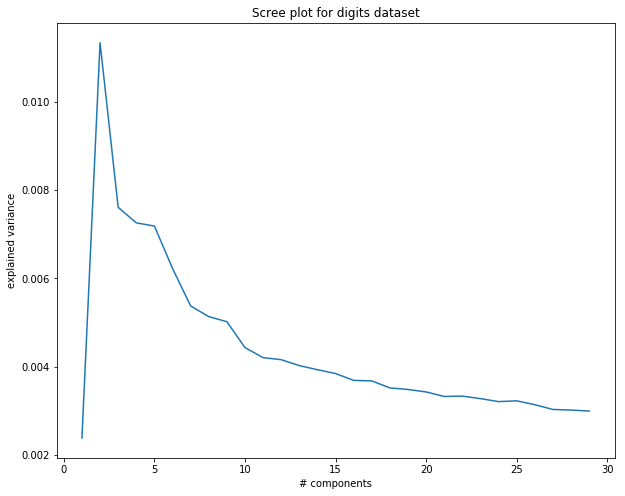

In [697]:
plt.figure(figsize=(10,8))
plt.plot(num_components[:], var_steps[:])
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

I used Non-Negative Matrix Factorization to get my 15 topics below.

In [698]:
nmf_model_tf = NMF(15)
doc_topic_tf = nmf_model_tf.fit_transform(doc_word_tf)

In [699]:
topic_word = pd.DataFrame(nmf_model_tf.components_.round(3), index = ["component_1","component_2", "component_3",
                                                                   "component_4","component_5", "component_6",
                                                                     "component_7","component_8", "component_9",
                                                                   "component_10", "component_11", "component_12",
                                                                     "component_13", "component_14", "component_15"], 
                          columns = tfidf.get_feature_names())
topic_word

,able,absolute,absolutely,accept,accessory,accommodate,across,add,addition,admit,...,worse,worth,wrap,writing,wrong,years,yesterday,young,yummy,zero
component_1,0.015,0.000,0.055,0.013,0.000,0.011,0.045,0.027,0.000,0.000,...,0.021,0.081,0.072,0.000,0.057,0.000,0.017,0.000,0.137,0.000
component_2,0.000,0.004,0.019,0.004,0.095,0.000,0.013,0.001,0.021,0.004,...,0.000,0.024,0.007,0.000,0.019,0.000,0.023,0.021,0.000,0.000
component_3,0.064,0.011,0.015,0.009,0.000,0.012,0.023,0.014,0.000,0.006,...,0.000,0.001,0.000,0.000,0.014,0.102,0.012,0.000,0.000,0.019
component_4,0.000,0.005,0.007,0.003,0.000,0.000,0.018,0.003,0.004,0.000,...,0.000,0.007,0.000,0.007,0.011,0.000,0.000,0.008,0.012,0.035
component_5,0.004,0.030,0.029,0.009,0.000,0.000,0.047,0.008,0.016,0.000,...,0.007,0.000,0.010,0.000,0.000,0.000,0.000,0.019,0.046,0.000
component_6,0.024,0.001,0.000,0.007,0.000,0.006,0.074,0.019,0.037,0.013,...,0.010,0.014,0.001,0.000,0.017,0.000,0.000,0.042,0.015,0.000
component_7,0.002,0.005,0.000,0.018,0.000,0.000,0.033,0.000,0.000,0.014,...,0.000,0.073,0.053,0.011,0.029,0.000,0.000,0.005,0.037,0.000
component_8,0.006,0.000,0.068,0.015,0.000,0.000,0.003,0.013,0.004,0.000,...,0.000,0.136,0.021,0.011,0.010,0.000,0.000,0.000,0.000,0.000
component_9,0.014,0.029,0.028,0.004,0.000,0.024,0.041,0.020,0.010,0.019,...,0.001,0.060,0.009,0.012,0.034,0.000,0.013,0.000,0.039,0.000
component_10,0.017,0.000,0.036,0.000,0.000,0.000,0.006,0.000,0.023,0.000,...,0.010,0.054,0.018,0.019,0.002,0.000,0.012,0.000,0.000,0.019


In [700]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf_model_tf, tfidf.get_feature_names(), 10)


Topic  0
food, chicken, delicious, lunch, dish, rice, portion, chinese, taste, fry

Topic  1
store, selection, product, gift, shoes, clothing, looking, everything, unique, stuff

Topic  2
hair, haircut, salon, stylist, color, appointment, listen, long, getting, nail

Topic  3
pizza, slice, crust, cheese, delivery, late, night, topping, italian, salad

Topic  4
coffee, cafe, breakfast, latte, bagel, morning, cute, pastry, delicious, toast

Topic  5
drink, beer, bartender, night, cool, happy, game, cocktail, music, bars

Topic  6
sandwich, breakfast, lunch, chicken, salad, bread, deli, cheese, fresh, delicious

Topic  7
price, reasonable, quality, reasonably, high, selection, cheap, decent, fair, affordable

Topic  8
restaurant, dinner, night, reservation, menu, wait, table, lunch, around, brunch

Topic  9
sushi, roll, fish, fresh, japanese, lunch, rice, fast, salmon, craving

Topic  10
experience, first, take, amaze, call, tell, location, nail, give, could

Topic  11
shop, flower, beau

From these, I made topic vectors for each of the businesses in my dataset.

In [701]:
yelp_reviews['component_1'] = topic_vectors_df.component_1.values
yelp_reviews['component_2'] = topic_vectors_df.component_2.values
yelp_reviews['component_3'] = topic_vectors_df.component_3.values
yelp_reviews['component_4'] = topic_vectors_df.component_4.values
yelp_reviews['component_5'] = topic_vectors_df.component_5.values
yelp_reviews['component_6'] = topic_vectors_df.component_6.values
yelp_reviews['component_7'] = topic_vectors_df.component_7.values
yelp_reviews['component_8'] = topic_vectors_df.component_8.values
yelp_reviews['component_9'] = topic_vectors_df.component_9.values
yelp_reviews['component_10'] = topic_vectors_df.component_10.values
yelp_reviews['component_11'] = topic_vectors_df.component_11.values
yelp_reviews['component_12'] = topic_vectors_df.component_12.values
yelp_reviews['component_13'] = topic_vectors_df.component_13.values
yelp_reviews['component_14'] = topic_vectors_df.component_14.values
yelp_reviews['component_15'] = topic_vectors_df.component_15.values

In [702]:
yelp_reviews.head()

,index,reviews,total,reviews_text,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15
0,'āina,"[{'id': '0J2EIqZij53TR8_KqyS5MQ', 'url': 'http...",939,been months since lovely meal with friends sti...,0.00279,0.00000,0.00130,0.00000,0.00000,0.07931,0.00189,0.00000,0.05152,0.00000,0.00041,0.00000,0.01917,0.00000,0.00060
1,100% Sweet Cafe,"[{'id': 'gbMTDQ-ZdeH0hQ-Q9aW0Kw', 'url': 'http...",532,very good food amazing flavors everytime have ...,0.02724,0.00680,0.00493,0.00000,0.00000,0.00000,0.00000,0.00381,0.00758,0.00000,0.06052,0.01293,0.01860,0.00243,0.00196
2,1275 café,"[{'id': 'AxS7Mw7RHCCwUfdccsT0UQ', 'url': 'http...",1,monday night dreading impending tuesday schedu...,0.00000,0.00000,0.00145,0.00042,0.00000,0.07452,0.00000,0.00297,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,20th Salon and Barber,"[{'id': 'up3Okf9LgrXFsepsUnuvwg', 'url': 'http...",354,have been going hrte last three years will kee...,0.00000,0.00000,0.13192,0.00000,0.00000,0.00257,0.00000,0.00079,0.00000,0.00517,0.00000,0.00000,0.06592,0.00000,0.08444
4,23rd & Mission Produce,"[{'id': 'yJNP6oGr1-ibk6Caf5VczQ', 'url': 'http...",22,shop this produce market very often because fr...,0.00192,0.00313,0.00000,0.00000,0.00176,0.00000,0.00777,0.00000,0.00349,0.00262,0.02409,0.05310,0.03199,0.00000,0.02877


In [703]:
yelp_reviews.to_pickle('./review_vectors.pkl')
topic_vectors_df.to_pickle('./topic_vectors.pkl')